# Training a Phoneme Language Model #
In this notebook I train a language model over English sounds (also known as [phonemes](https://en.wikipedia.org/wiki/Phoneme)). The data for English pronunciations comes from the CMU Pronouncing Dictionary. The pronunciations in the pronouncing dictionary are in [ARPABET](https://en.wikipedia.org/wiki/ARPABET), a set of symbols representing English sounds. So in ARPABET "fish" is pronounced as /F IH1 SH/.

By training on tens of thousands of pronunciations the model will hopefully learn [English phonotactics](https://en.wikipedia.org/wiki/Phonotactics#English_phonotactics), the rules that govern what sounds like a valid English word. For example, /F AH1 N/ ("fun") sounds good, but /NG S ER1/ (maybe represented as "ngsr") does not.


Check out the notebook `Phoneme Exploration.ipynb` if you want to see the model used.

In [1]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from torch.nn import functional as F
from tqdm.notebook import tqdm

from sonorous.languagemodel import LanguageModel, ModelParams, Vocabulary
from sonorous.pronunciationdata import load_pronunciations
from sonorous.utils import split_data

## The Data ##
The data for this model comes from the [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict), which contains over one hundred thousand pronunciations. Each pronuncation is in [ARPABET](https://en.wikipedia.org/wiki/ARPABET), a set of symbols for representing English speech sounds. In ARPABET the word "fish" is represented by the sequence of phonemes /F IH1 SH/. You can probably guess the first and third sounds. The vowel in the middle has "1" at the end to indicate it has the primary stress.

I'll use the `load_pronunciations` function to load the Pronouncing Dictionary into a Pandas DataFrame.

In [2]:
pronunciations = load_pronunciations()
print(f"There are {len(pronunciations):,} pronunciations.")
print()
print("Sample of 5 pronunciations:")
pronunciations.sample(5)

There are 124,567 pronunciations.

Sample of 5 pronunciations:


,pronunciation,num_phonemes,num_syllables,num_primary_stressed_syllables
word,,,,
pappas,"(ˈ, p, æ, p, ə, s)",5,2,1
bastedo,"(b, ɑː, ˈ, s, t, eɪ, d, oʊ)",7,2,1
moakley,"(ˈ, m, oʊ, k, l, i)",5,2,1
thur,"(ˈ, ð, ɝː)",2,0,1
sankyo,"(ˈ, s, æ, ŋ, k, j, oʊ)",6,2,1


Here is the pronunciation for "fish":

In [3]:
pronunciations.loc['fish']

pronunciation                     (ˈ, f, ɪ, ʃ)
num_phonemes                                 3
num_syllables                                1
num_primary_stressed_syllables               1
Name: fish, dtype: object

And here are all of the pronunciations for the word "tomato":

In [4]:
pronunciations.loc['tomato']

,pronunciation,num_phonemes,num_syllables,num_primary_stressed_syllables
word,,,,
tomato,"(t, ə, ˈ, m, eɪ, ˌ, t, oʊ)",6,3,1
tomato,"(t, ə, ˈ, m, ɑː, ˌ, t, oʊ)",6,2,1


## The Model ##
The module `languagemodel.py` contains a class `LanguageModel` that implements a simple neural language model. It's a PyTorch neural network comprised of the following layers:
1. **Embedding layer** to translate each phoneme into a dense vector. Note that in the code this is called the _encoder since it encodes input phonemes into a representation the model can work with.
2. An recurrent neural network (**RNN**) layer that processes each input phoneme sequentially and for each step generates (a) a hidden representation to pass on to the next step and (b) an output.
3. A **linear layer** that decodes the outputes (2b) into distributions over each phoneme. Note that in the code this is called the _docoder since it decodes the model's internal representations back into phonemes.

Let's go through a simple example of what happens when we pass the pronunciation /F IH1 SH/ through the model. Ultimately what I want ouf of the model is a prediction at each position of what the next phoneme should be. For example, when a well trained model is sees /F IH1/ it should know that /SH/ is likely, or at least not unlikely.

First I'll create a `Vocabulary` instance by passing in all the pronunciations. The `vocab` is used to convert phonemes into integer indices that the neural network handle. It does a few other things too, which you can see below. The `Vocabulary` class's code is in `sonorous/languagemodel.py`.

In [5]:
print(''.join(pronunciations.loc['fish'].pronunciation))

ˈfɪʃ


In [6]:
vocab = Vocabulary.from_texts(pronunciations.pronunciation.values)

print(f"There are {len(vocab)} distinct phonemes.")
print()
print("Looking up the int index for /ʃ/:", vocab['ʃ'])
print()
print("Checking whether /ʃ/ is in the vocabulary:", 'ʃ' in vocab)
print()
print("Looking up the phoneme for a specific int index:", vocab.token_from_idx(vocab['ʃ']))
print()
print("Encoding /ˈfɪʃ/:", vocab.encode_text(tuple("ˈfɪʃ")))

There are 47 distinct phonemes.

Looking up the int index for /ʃ/: 31

Checking whether /ʃ/ is in the vocabulary: True

Looking up the phoneme for a specific int index: ʃ

Encoding /ˈfɪʃ/: [ 1  4 38  9 31  2]


Now I'll define the model. Note that I'm not actually fitting the model to any data so the output will be random. The hyperparameters aren't optimal, but again that doesn't matter here since I just want to show the flow of data through the network.

The `ModelParams` class (from `sonorous/languagemodel.py` encapsulates hyperparameters and options for the model).

In [7]:
model_params = ModelParams(
    rnn_type='rnn', embedding_dimension=10, hidden_dimension=3, num_layers=1,
    max_epochs=3, early_stopping_rounds=3
)

language_model = LanguageModel(vocab, model_params, 'cpu')

Now I'll walk through what happens when we pass the word "fish" /F IH1 SH/ through the model:

In [8]:
fish_pronunciation = tuple("ˈfɪʃ")

The `Vocabulary.encode_text` function we saw earlier does a few things. First, it adds dummy `<START>` and `<END>` tokens to the pronunciation indicating its start and end. This allows the model to learn transition probabilities from the start of the word to the first phoneme, and from the last phoneme to the end of the word.

It then converts every phoneme to its ingeter index.

In [9]:
fish_input = vocab.encode_text(fish_pronunciation)
print(fish_input)
print()
for idx in fish_input:
    phoneme = vocab.token_from_idx(idx)
    print(f'{idx} => {phoneme}')

[ 1  4 38  9 31  2]

1 => <START>
4 => ˈ
38 => f
9 => ɪ
31 => ʃ
2 => <END>


And now we're ready to pass the input into the model's `forward` function, which takes in inputs and outputs predictions. This model's `forward` function expects a Tensor of dimension `(batch_size, NUMBER OF STEPS)`. A step here refers to a step forward in the sequence, so /<START> F IH1 SH <END>/ has 5 steps.

In [10]:
print("Input's shape:", fish_input.shape)
fish_batch_input = torch.LongTensor(fish_input).unsqueeze(0)
print("Batch input's shape:", fish_batch_input.shape)

Input's shape: (6,)
Batch input's shape: torch.Size([1, 6])


The first thing the `forward` function does is embed each phoneme using an [nn.Embedding](https://pytorch.org/docs/stable/nn.html#embedding). Each phoneme has a dedicated embedding vector of length `embedding_dimension`, so the shape of `embedded` is `(batch size, number of steps, embedding_dimension)`.

In [11]:
embedded = language_model._encoder(fish_batch_input)
print(embedded.shape)
print()
embedded

torch.Size([1, 6, 10])



tensor([[[-0.0702, -0.0878,  1.0488,  1.6095,  2.1078,  1.2971,  0.4692,
           0.2504,  0.4908, -0.2086],
         [-0.5052, -0.1303,  2.6945,  0.4872, -1.0471, -0.3601, -1.2850,
          -2.1139, -1.3659, -1.0605],
         [ 1.2538,  0.0173, -0.0690,  0.7895,  1.7514,  0.1740, -0.4033,
          -0.7597, -0.5434,  0.4726],
         [ 2.4930, -0.5973, -1.6396,  0.0426,  1.0717,  1.9867,  0.4249,
          -0.5035,  0.9816,  1.4325],
         [ 0.1882, -1.6113,  0.6758,  0.2947, -1.0157,  3.7469, -1.7828,
          -0.6747,  0.9082,  0.2381],
         [ 0.3316,  1.5206,  0.7191,  0.3741,  1.2754, -0.3685, -0.2283,
           0.2486, -0.9748, -0.6877]]], grad_fn=<EmbeddingBackward>)

I'll pass `embedded` to the [RNN layer](https://pytorch.org/docs/stable/nn.html#recurrent-layers), resulting in `rnn_output` and `hidden_state`. I won't go into detail on how RNNs work since there are many detailed posts on the web you can read, but the basic idea is a cell is applied sequentially to every token (i.e. step) in the input. At each step an output and a hidden state are produced. The hidden state can be passed on to the next step, and the output can be used to make a prediction.

The `rnn` layer below operates on the full sequence, so the results are for the entire sequence.

In [12]:
rnn_output, hidden_state = language_model._rnn(embedded)
print(rnn_output.shape)
print()
rnn_output

torch.Size([1, 6, 3])



tensor([[[ 0.9590, -0.2611, -0.3243],
         [-0.4472,  0.9664, -0.9934],
         [ 0.8957, -0.6811, -0.6081],
         [ 0.9948, -0.7902,  0.5413],
         [ 0.8693,  0.9834, -0.6951],
         [ 0.7104, -0.4971, -0.3664]]], grad_fn=<TransposeBackward1>)

For our application we can ignore the `hidden_state`-- the `rnn_output` is the interesting part. The first dimension is for the batch, and we only have a single input in our batch. The second dimension is for each of the input phonemes. The third dimension corresponds to `hidden_dimension`: you can think of this as the state of the RNN at each step.

As I said at the beginning of this section, I want the output of the RNN at each position to be predictions for the *next* position. So I'll apply a [linear layer](https://pytorch.org/docs/stable/nn.html#linear) to the `rnn_output`, resulting in a vector the size of the vocabularly at each position. The [softmax](https://pytorch.org/docs/stable/nn.functional.html#softmax) function normalizes the outputs into probability distributions for each prediction.

In [13]:
outputs = language_model._decoder(rnn_output)
probabilities = F.softmax(outputs, dim=-1).squeeze()
probabilities.shape

torch.Size([6, 47])

The shape of `probabilities` is (5, 42) because each of the five tokens in /ˈfɪʃ/ gets a a probability distribution over each of the 42 phonemes in the vocabulary.

The first phoneme in the input is the `<START>` token; let's see what the model thinks should come next.

In [14]:
probabilities_for_first_phoneme = probabilities[0]
most_likely_first_phoneme_idx = probabilities_for_first_phoneme.argmax().item()
most_likely_first_phoneme = vocab.token_from_idx(most_likely_first_phoneme_idx)
most_likely_first_phoneme

'w'

So the model predicts /ŋ/ to be the first phoneme in the word. Since the model isn't fit yet this is just a random guess. In order to get the model to make good predictions I'll need to first train a good model.

## Finding the Best Model ##
In this section I'll train a number of models on the train set and select the one that has the lowest error on the dev set. I'll split the DataFrame of pronunciations into three DataFrames, with 79% for training, 20% for dev/validation, and 1% for testing of the final model.

In [15]:
train_pronunciations, dev_pronunciations, test_pronunciations = split_data(pronunciations, dev_proportion=.2, test_proportion=.01)
len(train_pronunciations), len(dev_pronunciations), len(test_pronunciations)

(98407, 24914, 1246)

Note that I ran a larger parameter search before and saw that GRUs were consistently outperforming LSTMs and vanilla RNNs. There are 12 (4 * 3) models to train, and for each one I'm measuring train and dev error at every epoch. So if each model trains for the maximum of 2,000 epochs I would end up with 12 * 2,000 = 24,000 models to choose from. There's a good chance I'm overfitting the dev set with such a large search, but I'll inspect the learning curves to try to avoid selecting an iteration that randomly did well.

While each model trains for a maximum of 2000 epochs, it stops early if the dev error does not decrease for three epochs in a row. Since I'm going to be selecting the model with the lowest dev error there's no reason to keep training a model once it's started overfitting. Alternatively I could train all models to convergence and then add regularization to reduce the complexity and identify the sweet spot, but that's far more time consuming because it requires training more models and each of them for longer.

* check errors before fitting
* overfit a small set

In [17]:
%%time

model_parameters = ModelParams(rnn_type='gru', num_layers=1, max_epochs=1000, early_stopping_rounds=3,
                              embedding_dimension=100, hidden_dimension=20)
model = LanguageModel(vocab, model_parameters, device_name='cuda')

train_losses, dev_losses = model.fit(
    train_pronunciations.pronunciation.values.tolist(),
    dev_pronunciations.pronunciation.values.tolist(),
)

Epoch 1: train loss: 1.1036	dev loss: 0.9862                                                                                             
	Generated: in train: 1%, assess: 0%, novel: 99%
	 ʒ v ə i
	 eɪ j f j i aʊ n ə ˌ aɪ ˈ
	 ˈ ʒ i p l
	 ˈ ɪ z uː j θ ʌ d ɛ uː t
	 r ʃ dʒ uː ʌ ɔɪ ɝ ɝ p aʊ h ʌ h eɪ
Epoch 2: train loss: 0.8437	dev loss: 0.7338                                                                                             
	Generated: in train: 4%, assess: 0%, novel: 96%
	 
	 ˈ p aɪ p p z
	 b ʌ ɑː ŋ i
	 ˈ ŋ l ʒ tʃ ɔɪ ɪ
	 ˈ θ oʊ iː
Epoch 3: train loss: 0.7594	dev loss: 0.6554                                                                                             
	Generated: in train: 4%, assess: 0%, novel: 96%
	 ˈ r eɪ n d
	 
	 ˈ ʌ eɪ n θ k ɝ
	 ˈ ɔɪ t l
	 ˈ ɑː k ɪ ʊ t eɪ uː t i
Epoch 4: train loss: 0.7143	dev loss: 0.6142                                                                                             
	Generated: in train: 3%, assess: 1%, novel: 96%
	 ˈ b t h oʊ

Epoch 31: train loss: 0.5535	dev loss: 0.4730                                                                                             
	Generated: in train: 11%, assess: 3%, novel: 86%
	 ˈ b ʌ l z ɝ
	 ˈ t ɪ f t ɝ ə l
	 ˈ d ɛ k ə v ɝ
	 ˈ tʃ æ l s ɝ
	 ˈ m ɪ k ɝː d
Epoch 32: train loss: 0.5528	dev loss: 0.4723                                                                                             
	Generated: in train: 13%, assess: 2%, novel: 85%
	 ˈ b r ɛ l ə ŋ
	 ˌ s n ɑː ʒ iː ˈ æ l s k
	 ˈ oʊ ˌ æ n b
	 ˈ n ɛ tʃ ɪ k
	 ˈ f r aɪ d ə d
Epoch 33: train loss: 0.5520	dev loss: 0.4716                                                                                             
	Generated: in train: 15%, assess: 4%, novel: 81%
	 ˈ h ɑː r p t i
	 ˈ g ɛ l ɪ v ɪ t
	 ˈ b j r uː d
	 ˈ g ɛ r ɪ d
	 m ə ˈ s p k eɪ n
Epoch 34: train loss: 0.5511	dev loss: 0.4709                                                                                             
	Generated: in train: 10%, assess: 1%, novel

Epoch 60: train loss: 0.5387	dev loss: 0.4606                                                                                             
	Generated: in train: 11%, assess: 2%, novel: 87%
	 ɪ ˈ h ɑː r t ə n t ɪ ŋ
	 ˈ t ɑː r ɔ n
	 k ɑː b ɔ ˈ k ɑː t ə l
	 ˈ r ɔɪ s
	 ˈ g æ s t r ə n
Epoch 61: train loss: 0.5384	dev loss: 0.4604                                                                                             
	Generated: in train: 13%, assess: 3%, novel: 84%
	 ˈ h aʊ s t
	 r iː ˈ d ɝː t w i
	 ˈ æ n ɪ t s
	 ˈ k aɪ oʊ s n ɝ oʊ m
	 ˈ f w eɪ z ɛ d
Epoch 62: train loss: 0.5381	dev loss: 0.4601                                                                                             
	Generated: in train: 14%, assess: 1%, novel: 85%
	 ˈ l ɛ g n ə n
	 ˈ s æ n d oʊ
	 ˈ k æ s
	 ˌ s ɪ n ʃ ə n ˈ p ɑː r t s
	 ˈ æ n d ˌ h eɪ m
Epoch 63: train loss: 0.5380	dev loss: 0.4600                                                                                             
	Generated: in train: 10%

Epoch 89: train loss: 0.5333	dev loss: 0.4562                                                                                             
	Generated: in train: 15%, assess: 0%, novel: 85%
	 ˈ h ɔ r f
	 ɛ ˈ r ɛ s l i
	 ˈ m ʌ m ˌ p l oʊ l
	 ˈ æ n d iː n ə t s
	 ˈ s iː d
Epoch 90: train loss: 0.5333	dev loss: 0.4561                                                                                             
	Generated: in train: 9%, assess: 1%, novel: 90%
	 ˈ oʊ b oʊ
	 ˌ k æ dʒ ə ˌ s ɪ n d ɝ ˈ t oʊ s t
	 ˈ g æ s t r ə s
	 ˈ h æ n d ɝ l oʊ
	 ˈ dʒ ɛ t s i
Epoch 91: train loss: 0.5331	dev loss: 0.4561                                                                                             
	Generated: in train: 13%, assess: 3%, novel: 84%
	 ˈ p ɛ g p k ə n
	 ˈ ʃ ʌ b iː ə n
	 ˈ h æ s ə ˌ r eɪ t
	 ˈ s aʊ n t s
	 ˌ r uː ˈ ɛ s r i
Epoch 92: train loss: 0.5331	dev loss: 0.4560                                                                                             
	Generated: in train: 12

Epoch 118: train loss: 0.5309	dev loss: 0.4543                                                                                             
	Generated: in train: 17%, assess: 3%, novel: 80%
	 ˈ aʊ m ɝ
	 ɪ ˈ ɝː t
	 d ɪ f ə ˈ s t ɑː l i
	 ˈ r æ ŋ k s ɝ z
	 ˈ d æ n z ə n
Epoch 119: train loss: 0.5308	dev loss: 0.4542                                                                                             
	Generated: in train: 14%, assess: 1%, novel: 85%
	 k æ ˈ s ɛ n t iː r ə
	 
	 p r ə ˈ v uː ʃ ə m ə k
	 ˈ h ɛ r
	 ˈ dʒ ɪ s t z
Epoch 120: train loss: 0.5308	dev loss: 0.4542                                                                                             
	Generated: in train: 11%, assess: 3%, novel: 86%
	 ˌ m ɪ ˈ l ɪ l ə m
	 ˈ r æ v d
	 ˈ l iː v
	 ˈ h æ r ɪ m ə
	 p r æ ˈ t ɑː f d
Epoch 121: train loss: 0.5307	dev loss: 0.4542                                                                                             
	Generated: in train: 12%, assess: 1%, novel: 87%
	 ˈ s p

Epoch 148: train loss: 0.5293	dev loss: 0.4531                                                                                             
	Generated: in train: 15%, assess: 2%, novel: 83%
	 ˈ p l aʊ z
	 ˈ p ɑː r f oʊ
	 ˈ n ɪ ˌ g r ɪ k ɝ d
	 ˈ s ɛ t
	 ˈ k r aɪ r ə n
Epoch 149: train loss: 0.5293	dev loss: 0.4532                                                                                             
	Generated: in train: 12%, assess: 1%, novel: 87%
	 ˈ k ʌ l d z
	 ˈ b ɛ t ɪ l
	 b ɔ r ˈ ʃ ɔ n z
	 ˈ s iː z ə l ɝ
	 ˈ d ɔ l z
Epoch 150: train loss: 0.5294	dev loss: 0.4532                                                                                             
	Generated: in train: 14%, assess: 2%, novel: 84%
	 ˈ t aʊ n ˌ tʃ ɪ n s ə n
	 ˈ ʃ ɛ p ˌ l æ p ə l ɪ s t
	 ˈ t ɑː d iː ə l
	 ˈ h ɑː n d ɝ ˌ l ɛ t s
	 ˈ k w iː n i
CPU times: user 20min 12s, sys: 1min 6s, total: 21min 18s
Wall time: 20min 17s


Early stopping because of no decrease in 3 epochs.


([1.1036094570775852,
  0.8436986849933503,
  0.7593890346064368,
  0.7142919638836622,
  0.6827820520739124,
  0.6585459344478072,
  0.6397948564493996,
  0.6263673148779023,
  0.6151490808569349,
  0.6061084125504329,
  0.5990127835470382,
  0.5930243306423786,
  0.5879646833771807,
  0.5837700006839988,
  0.5802721241679054,
  0.5773340510623292,
  0.5746628072301132,
  0.5722927667713189,
  0.5701736787136268,
  0.5682149583007987,
  0.5664557019719216,
  0.5647777990809897,
  0.5631747640938567,
  0.5616779143599051,
  0.5602522044755545,
  0.5589182815339883,
  0.5576782485464997,
  0.556496865144055,
  0.5554179067594209,
  0.5544824393690825,
  0.5535344802965141,
  0.5527828994594833,
  0.5519750950300111,
  0.5511186626509402,
  0.5503950765280766,
  0.549635472584408,
  0.5489427600438943,
  0.5483249656282391,
  0.5476590450837193,
  0.5471173402514103,
  0.546583084297366,
  0.5459890213701928,
  0.5455426814033151,
  0.5448852699436737,
  0.5444035458911805,
  0.543945514

In [61]:
%%time

model_parameters = ModelParams(rnn_type='gru', num_layers=1, max_epochs=1000, early_stopping_rounds=3,
                              embedding_dimension=20, hidden_dimension=20)
model2 = LanguageModel(vocab, model_parameters, device_name='cuda')

train_losses, dev_losses = model2.fit(
    train_pronunciations.pronunciation.values.tolist(),
    dev_pronunciations.pronunciation.values.tolist(),
)

Epoch 1: train loss: 1.2172	dev loss: 1.0880                                                                                             
	Generated: in train: 0%, assess: 0%, novel: 100%
	 ˌ v ʊ ə h uː
	 f ɝː i ɛ uː ŋ dʒ
	 oʊ θ f
	 k ʊ
	 ʊ iː tʃ aʊ t aʊ t g tʃ z
Epoch 2: train loss: 0.9410	dev loss: 0.8146                                                                                             
	Generated: in train: 0%, assess: 0%, novel: 100%
	 v aʊ ɝ i g ɔ ɝ i ə w
	 ɑː k
	 b n
	 aʊ t uː ə ɛ ˈ ə ə j æ ɛ aɪ
	 tʃ ð s
Epoch 3: train loss: 0.8466	dev loss: 0.7287                                                                                             
	Generated: in train: 0%, assess: 0%, novel: 100%
	 s ɛ h z z
	 iː æ m ŋ
	 tʃ ˈ ə b h f
	 l tʃ ɪ ʒ ɔɪ
	 ɑː ˈ tʃ s ə f ə
Epoch 4: train loss: 0.7842	dev loss: 0.6733                                                                                             
	Generated: in train: 0%, assess: 0%, novel: 100%
	 θ iː ʊ j ɛ ɔɪ v v ð n
	 l 

Epoch 31: train loss: 0.5591	dev loss: 0.4775                                                                                             
	Generated: in train: 13%, assess: 3%, novel: 84%
	 ˈ θ ɑː r t ɝ
	 ˈ p f ɛ r d ɝ s
	 ˈ b ɔ l i
	 ˈ s ɑː m ɪ z
	 k r iː ˈ iː t ə l θ
Epoch 32: train loss: 0.5581	dev loss: 0.4767                                                                                             
	Generated: in train: 10%, assess: 0%, novel: 90%
	 ˈ eɪ t ɪ k s k i
	 ˈ h ɪ k t s
	 ˈ dʒ ɪ k ə b ɝ
	 ˈ θ iː z ɪ k
	 ˈ p æ n d ɪ s n i
Epoch 33: train loss: 0.5572	dev loss: 0.4759                                                                                             
	Generated: in train: 5%, assess: 2%, novel: 93%
	 m ə k ˈ ɑː n d ɪ ʃ
	 b ɑː n r ə ˈ k ʌ r ˌ k oʊ ˌ f eɪ l z
	 r iː ˈ æ n d ɝ oʊ
	 ˈ b iː ˌ b ɔ z ə t
	 s ə ˈ w ɪ n ə t ɝ
Epoch 34: train loss: 0.5562	dev loss: 0.4751                                                                                             
	Genera

Epoch 61: train loss: 0.5420	dev loss: 0.4631                                                                                             
	Generated: in train: 11%, assess: 1%, novel: 88%
	 ˈ k r æ t ʃ ə n
	 ˈ s t r æ k t ɝ
	 ˈ ɑː s n ɝ
	 s iː ˈ v iː n ɪ d
	 ˈ f ɝː l aɪ z
Epoch 62: train loss: 0.5416	dev loss: 0.4628                                                                                             
	Generated: in train: 11%, assess: 1%, novel: 88%
	 ˌ ɛ t ɝ ˈ t r iː s ə n
	 ˈ ɔ r s k i
	 ˈ k ɑː g ə p l ɪ ŋ z
	 ˈ f ɛ v l ə m b ɛ k
	 ˈ r iː z s
Epoch 63: train loss: 0.5415	dev loss: 0.4627                                                                                             
	Generated: in train: 14%, assess: 0%, novel: 86%
	 ˈ h eɪ z d
	 d ˈ l æ ʃ z
	 ˈ æ d h uː
	 ˈ p ʌ s t r iː v ɝ z
	 ˈ ɑː d l ɪ k
Epoch 64: train loss: 0.5411	dev loss: 0.4625                                                                                             
	Generated: in train: 12%, assess:

Epoch 91: train loss: 0.5363	dev loss: 0.4585                                                                                             
	Generated: in train: 9%, assess: 2%, novel: 89%
	 ˈ ɑː r n ɪ ŋ
	 ˈ t ɛ v ɝ z
	 ˌ ɪ n iː ˈ v ɛ iː ə b ə l t
	 dʒ ə ˈ g ɑː d d i
	 d iː ˈ ɛ l t
Epoch 92: train loss: 0.5362	dev loss: 0.4584                                                                                             
	Generated: in train: 14%, assess: 1%, novel: 85%
	 r ə ˌ k ɑː r ˈ p r iː
	 ˈ r ɪ ˈ t oʊ t s
	 ˈ w ʌ l b ə l
	 ˈ s ɛ r ɪ t ə s
	 ˈ l aɪ v ɪ ŋ
Epoch 93: train loss: 0.5360	dev loss: 0.4582                                                                                             
	Generated: in train: 10%, assess: 1%, novel: 89%
	 ˌ r ɪ ð ɝ ˈ ɪ k s k ə ˈ b ɑː r t ə
	 d ɝ ˈ ɪ t ˌ s t ɔ m ə n d n ɝ i
	 ˈ k æ f uː ˌ k w ʊ d
	 ˈ z oʊ
	 ɛ ˈ m iː d ə n
Epoch 94: train loss: 0.5359	dev loss: 0.4581                                                                                   

Epoch 120: train loss: 0.5333	dev loss: 0.4560                                                                                             
	Generated: in train: 17%, assess: 1%, novel: 82%
	 ˈ b w eɪ n l i
	 ˈ k j uː ˈ æ ŋ k ɝ
	 ˈ l ɛ θ ɑː dʒ
	 ˈ f ɑː r t d
	 ˈ ɪ r ɪ ˌ l eɪ b iː d n ɝ
Epoch 121: train loss: 0.5330	dev loss: 0.4557                                                                                             
	Generated: in train: 13%, assess: 0%, novel: 87%
	 ˈ g r aɪ dʒ
	 ˈ b l ʌ n d d
	 ˈ f r aʊ ɝ
	 ˈ s aʊ n d ɝ
	 ˈ t r ɛ θ ɝ
Epoch 122: train loss: 0.5329	dev loss: 0.4557                                                                                             
	Generated: in train: 10%, assess: 5%, novel: 85%
	 ˈ s eɪ h aɪ ˌ h ɔ r
	 ˈ m ɪ n t r ə s
	 ˈ t w ɔ k s k i
	 ˈ d ɔ ˌ f ɝː n
	 ˈ b eɪ dʒ ə
Epoch 123: train loss: 0.5328	dev loss: 0.4556                                                                                             
	Generated: in train: 7%, assess

Epoch 149: train loss: 0.5311	dev loss: 0.4543                                                                                             
	Generated: in train: 12%, assess: 0%, novel: 88%
	 ˈ n ʌ ŋ g ɝ z
	 ˈ n iː d ˌ v ɪ l
	 ˈ n oʊ
	 ˈ ɛ s t ə ˌ l aɪ t
	 ˌ t r ɪ dʒ ə ˈ l ɛ n i
Epoch 150: train loss: 0.5311	dev loss: 0.4542                                                                                             
	Generated: in train: 10%, assess: 2%, novel: 88%
	 ˈ b uː d
	 ˈ f r aɪ k ə m
	 ˈ k r ɑː r z
	 ˌ d ɑː r ˈ t aɪ oʊ ˌ n eɪ t
	 ˈ k iː s t ə n
Epoch 151: train loss: 0.5310	dev loss: 0.4542                                                                                             
	Generated: in train: 9%, assess: 3%, novel: 88%
	 ˈ eɪ p ɪ n s ə n
	 ˈ ɛ tʃ ɝ θ
	 ˈ ɛ f p ɝ ˌ h iː t l i
	 d ɪ ˈ p uː z
	 ə ˈ m aɪ d z
Epoch 152: train loss: 0.5309	dev loss: 0.4541                                                                                             
	Generated: in train: 11

Epoch 178: train loss: 0.5298	dev loss: 0.4532                                                                                             
	Generated: in train: 14%, assess: 2%, novel: 84%
	 ˈ k s ʌ t ə tʃ ɪ k
	 ˈ k r oʊ d ə n
	 ɪ n ˈ f ɪ dʒ ɝ
	 p ɪ ˌ m ə n t ɑː l oʊ ˈ t ɑː n d ɪ ŋ
	 ˈ k l æ n n
Epoch 179: train loss: 0.5298	dev loss: 0.4532                                                                                             
	Generated: in train: 13%, assess: 2%, novel: 85%
	 ˈ dʒ oʊ v ɪ n z
	 ˈ ɑː r v iː i
	 ˈ f ɝː t ɪ ŋ
	 ˈ p ɛ m w ə ʃ n ə
	 ˈ d ɑː s ə f ɝ n s t
Epoch 180: train loss: 0.5297	dev loss: 0.4532                                                                                             
	Generated: in train: 11%, assess: 0%, novel: 89%
	 ˈ s p aɪ z
	 ˈ m ɪ k
	 ˈ s l æ d ʃ ə n
	 ˈ h j uː r
	 ˈ dʒ ɛ n tʃ f r ə n z
Epoch 181: train loss: 0.5296	dev loss: 0.4531                                                                                             
	Generated: 

Epoch 207: train loss: 0.5289	dev loss: 0.4524                                                                                             
	Generated: in train: 10%, assess: 2%, novel: 88%
	 ˌ æ n t r iː ˈ n ɑː k j ə n
	 ˈ m ɝː z
	 ˈ p oʊ f
	 ˈ r iː ˌ k aɪ
	 ˈ f iː l ɛ k
Epoch 208: train loss: 0.5288	dev loss: 0.4523                                                                                             
	Generated: in train: 15%, assess: 2%, novel: 83%
	 ˈ v ɑː g ə s ə m
	 ˈ f aɪ t s
	 ə ˈ h ɝː m ə n
	 d ɪ ˈ s t r ʌ n ʃ ɪ
	 ˈ w ɪ m p l ɝ
Epoch 209: train loss: 0.5288	dev loss: 0.4523                                                                                             
	Generated: in train: 8%, assess: 2%, novel: 90%
	 ˈ n ɝː ə n
	 ˌ n ɛ n ə n ɝ ˈ iː n ə
	 s ə ˈ t r ɪ tʃ ɪ k
	 l ɪ ˈ n ɪ l ə
	 ˈ k ʌ n ɝ l ɪ ŋ
Epoch 210: train loss: 0.5287	dev loss: 0.4523                                                                                             
	Generated: in train: 12%, a

Epoch 236: train loss: 0.5280	dev loss: 0.4517                                                                                             
	Generated: in train: 13%, assess: 3%, novel: 84%
	 ˈ d iː t
	 ˈ r oʊ l z
	 ˈ r iː n t ɝ
	 ˌ d ɪ n ə f r iː ˈ l ɛ dʒ
	 ɪ ˈ b r ɪ m ɪ n
Epoch 237: train loss: 0.5280	dev loss: 0.4516                                                                                             
	Generated: in train: 11%, assess: 1%, novel: 88%
	 ˈ d r ɔ t i
	 ˈ æ ŋ k æ n
	 ˌ ɪ n ˈ t ɛ k l ə k s
	 ˈ f ɛ s
	 ˈ dʒ ɔ r ə n
Epoch 238: train loss: 0.5280	dev loss: 0.4517                                                                                             
	Generated: in train: 7%, assess: 1%, novel: 92%
	 ˈ dʒ iː g
	 ˈ s t aɪ s ɪ z
	 ˈ m ɪ l ˌ f ɛ l t s
	 ˈ g eɪ ʒ ə n
	 ˌ k ɪ n ˈ t ɛ d
Epoch 239: train loss: 0.5279	dev loss: 0.4516                                                                                             
	Generated: in train: 12%, assess: 4%, novel:

Epoch 265: train loss: 0.5273	dev loss: 0.4511                                                                                             
	Generated: in train: 11%, assess: 1%, novel: 88%
	 d ɪ ˈ g æ n p ə l ɝ
	 ˈ g r ɪ b ɪ ʃ
	 ˈ k æ n d ə l b ɝ g
	 ˈ f r ɛ v ɝ
	 ˈ h oʊ l d ɪ ˌ n ɛ r i
Epoch 266: train loss: 0.5274	dev loss: 0.4511                                                                                             
	Generated: in train: 10%, assess: 0%, novel: 90%
	 ˈ s k ʌ ŋ k ə l b ɝ g ɝ
	 ˌ æ n ˈ d eɪ t s
	 ˈ b ʌ n
	 ˈ n ɛ ˌ t r æ s ɪ ŋ
	 ˈ t ɑː f l i
Epoch 267: train loss: 0.5274	dev loss: 0.4512                                                                                             
	Generated: in train: 3%, assess: 1%, novel: 96%
	 r ɪ ˈ m ɛ r ə k ə n t s
	 ˈ f r ɛ s
	 ˈ ɛ ˌ m ɛ l eɪ
	 ˈ k ɛ k s ə
	 b iː ˈ ɑː v ə
Epoch 268: train loss: 0.5273	dev loss: 0.4512                                                                                             
	Generated: in 

Epoch 294: train loss: 0.5269	dev loss: 0.4507                                                                                             
	Generated: in train: 7%, assess: 1%, novel: 92%
	 ˈ h oʊ v ɝ ɪ m
	 ˈ r ɪ n ɝ
	 ˈ l ɔ r m ɪ ŋ l ɪ s t
	 ˈ t r aɪ p ə n
	 ˈ h w ɪ d ˌ m oʊ v p ɝ
Epoch 295: train loss: 0.5268	dev loss: 0.4507                                                                                             
	Generated: in train: 10%, assess: 3%, novel: 87%
	 ˈ w æ f ə l aɪ t ɝ
	 ɑː r ˈ d oʊ z
	 ˈ h eɪ t ə s
	 ˈ θ l ə p ɝ ˌ g ɑː n
	 ˈ θ r æ s t ɪ ŋ
Epoch 296: train loss: 0.5268	dev loss: 0.4507                                                                                             
	Generated: in train: 10%, assess: 0%, novel: 90%
	 ˈ h iː p ə dʒ z
	 ˈ r eɪ s ə m
	 ˈ dʒ ʌ n h ɑː r t i
	 ˈ h ɛ m ɝ d
	 ˈ l ɪ t ə b i
Epoch 297: train loss: 0.5269	dev loss: 0.4507                                                                                             
	Generated: in tra

Early stopping because of no decrease in 3 epochs.


In [77]:
train_pronunciations.head()

,pronunciation,num_phonemes,num_syllables,num_primary_stressed_syllables
word,,,,
expands,"(ɪ, k, ˈ, s, p, æ, n, d, z)",8,2,1
rejecting,"(r, iː, ˈ, dʒ, ɛ, k, t, ɪ, ŋ)",8,2,1
chilmark,"(ˈ, tʃ, ɪ, l, ˌ, m, ɑː, r, k)",7,1,1
dworsky,"(ˈ, d, w, ɝː, s, k, i)",6,1,1
handyman,"(ˈ, h, æ, n, d, iː, ˌ, m, æ, n)",8,2,1


In [78]:
dev_pronunciations.head()

,pronunciation,num_phonemes,num_syllables,num_primary_stressed_syllables
word,,,,
hammon,"(ˈ, h, æ, m, ə, n)",5,2,1
podany,"(p, ə, ˈ, d, ɔ, n, i)",6,3,1
belliveau,"(ˈ, b, ɛ, l, ɪ, ˌ, v, oʊ)",6,3,1
cheese,"(ˈ, tʃ, iː, z)",3,0,1
relented,"(r, iː, ˈ, l, ɛ, n, ə, d)",7,2,1


In [82]:
len(train_pronunciations), len(dev_pronunciations)

(98407, 24914)

In [83]:
set(train_pronunciations.index) & set(dev_pronunciations.index)

{'chromosome',
 'hors',
 'rapids',
 'keogh',
 'erasers',
 'keanu',
 'gadhafi',
 'abuse',
 'aaronson',
 'fogarty',
 'ringler',
 'isolde',
 'pocahontas',
 'riches',
 'economy',
 'dyneer',
 'battlement',
 'messenger',
 'kesling',
 'voyaged',
 'seasonally',
 'overland',
 'molded',
 'commingling',
 'barentine',
 'atoll',
 'buchi',
 'internationale',
 'accompaniments',
 'untoward',
 'directory',
 'intercept',
 'janet',
 'affiliates',
 'blackening',
 'pena',
 'kjellberg',
 'feathery',
 'cottage',
 'interceptor',
 'ecologically',
 'increases',
 'hertz',
 'kokate',
 'mondrian',
 'transylvania',
 'riyadh',
 'whither',
 'tischler',
 'forearms',
 'golan',
 'fridays',
 'miasma',
 'comprises',
 'canister',
 'estimators',
 'corabelle',
 'michel',
 'gallstones',
 'cocksucker',
 'scheufler',
 'tended',
 'whaler',
 'outlasts',
 'bass',
 'abductor',
 'whippoorwills',
 'retreated',
 'saddam',
 'zeigler',
 'duets',
 'hovering',
 'wimbush',
 'respective',
 'bandages',
 'towering',
 'furlett',
 'anticipation

In [84]:
train_pronunciations.loc['keanu']

pronunciation                     (k, eɪ, ˈ, ɑː, n, uː)
num_phonemes                                          5
num_syllables                                         1
num_primary_stressed_syllables                        1
Name: keanu, dtype: object

In [86]:
dev_pronunciations.loc['keanu'].pronunciation

('k', 'iː', 'ˈ', 'ɑː', 'n', 'uː')

In [89]:
dev_pronunciations['perplexity'] = dev_pronunciations.pronunciation.apply(model2.perplexity_of_text)

In [90]:
train_pronunciations['perplexity'] = train_pronunciations.pronunciation.apply(model2.perplexity_of_text)

/home/ubuntu/sonorous/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
train_pronunciations.perplexity.describe()

count    9.840700e+04
mean     9.454545e+01
std      1.436103e+04
min      3.780680e+00
25%      8.714275e+00
50%      1.114043e+01
75%      1.494983e+01
max      2.599575e+06
Name: perplexity, dtype: float64

In [97]:
(dev_pronunciations.num_phonemes==1).mean()

0.0004013807497792406

In [115]:
pronunciations.loc['environment'].pronunciation

('ɪ', 'n', 'ˈ', 'v', 'aɪ', 'r', 'ə', 'n', 'm', 'ə', 'n', 't')

In [125]:
train_pronunciations.pronunciation.apply(lambda p: p[0]).value_counts()

ˈ     69549
ˌ      7943
m      2279
k      2037
d      2037
ə      1990
r      1726
p      1435
s      1273
b      1021
ɪ       806
l       666
f       563
t       550
v       501
g       455
ɑː      439
ɛ       420
n       366
h       327
æ       301
oʊ      242
dʒ      227
j       167
z       156
tʃ      141
ʃ       135
ɝ       129
iː      119
w        88
ɔ        81
aɪ       62
aʊ       48
eɪ       36
θ        35
ʒ        33
uː       16
ð         8
Name: pronunciation, dtype: int64

In [128]:
with open('model.pt', 'wb') as fh:
    model.save(fh)

In [126]:
model

LanguageModel(
  (_encoder): Embedding(47, 100)
  (_rnn): GRU(100, 20, batch_first=True)
  (_decoder): Linear(in_features=20, out_features=47, bias=True)
  (_dropout): Dropout(p=0, inplace=False)
)

In [127]:
model2

LanguageModel(
  (_encoder): Embedding(47, 20)
  (_rnn): GRU(20, 20, batch_first=True)
  (_decoder): Linear(in_features=20, out_features=47, bias=True)
  (_dropout): Dropout(p=0, inplace=False)
)

In [124]:
pron = ("ˈ", )
sorted(model.next_probabilities(pron).items(), key=lambda p: -p[1])

[('s', 0.1157408282160759),
 ('k', 0.08229496330022812),
 ('b', 0.07638482749462128),
 ('h', 0.0634717047214508),
 ('m', 0.06258977204561234),
 ('r', 0.05845705047249794),
 ('p', 0.051873404532670975),
 ('f', 0.04908735677599907),
 ('l', 0.0490451417863369),
 ('g', 0.04636289179325104),
 ('d', 0.04572166129946709),
 ('t', 0.04444989934563637),
 ('w', 0.03888579085469246),
 ('n', 0.029962318018078804),
 ('ʃ', 0.023488372564315796),
 ('æ', 0.021215857937932014),
 ('v', 0.01706729456782341),
 ('ɛ', 0.015526660718023777),
 ('dʒ', 0.015337788499891758),
 ('ɑː', 0.012288525700569153),
 ('tʃ', 0.011904851533472538),
 ('j', 0.011207259260118008),
 ('ɪ', 0.009802079759538174),
 ('oʊ', 0.008307610638439655),
 ('θ', 0.005722980946302414),
 ('z', 0.00557325966656208),
 ('ɔ', 0.005239768885076046),
 ('ʌ', 0.004391584079712629),
 ('eɪ', 0.004019142594188452),
 ('aʊ', 0.0030948740895837545),
 ('aɪ', 0.002752031432464719),
 ('iː', 0.0026345818769186735),
 ('ɝː', 0.0016971119912341237),
 ('uː', 0.00128

In [101]:
train_pronunciations[train_pronunciations.num_primary_stressed_syllables==0]

,pronunciation,num_phonemes,num_syllables,num_primary_stressed_syllables,perplexity
word,,,,,
can,"(k, ə, n)",3,1,0,1.148166e+02
mc,"(m, ɪ, k)",3,1,0,1.299671e+02
olmert,"(oʊ, l, m, ɝ, t)",5,2,0,1.879959e+02
did,"(d, ɪ, d)",3,1,0,1.382492e+02
de,"(d, ə)",2,1,0,3.509939e+03
...,...,...,...,...,...
sarin,"(s, ɑː, r, ɪ, n)",5,1,0,8.327210e+01
er,"(ɝ,)",1,1,0,2.599575e+06
this,"(ð, ɪ, s)",3,1,0,5.229038e+02


In [102]:
pronunciations.loc['did']

,pronunciation,num_phonemes,num_syllables,num_primary_stressed_syllables
word,,,,
did,"(ˈ, d, ɪ, d)",3,1,1
did,"(d, ɪ, d)",3,1,0


In [94]:
train_pronunciations.sort_values('perplexity', ascending=False).head()

,pronunciation,num_phonemes,num_syllables,num_primary_stressed_syllables,perplexity
word,,,,,
are,"(ɝ,)",1,1,0,2.599575e+06
er,"(ɝ,)",1,1,0,2.599575e+06
or,"(ɝ,)",1,1,0,2.599575e+06
a,"(ə,)",1,1,0,1.496432e+05
to,"(t, ə)",2,1,0,9.789262e+03


In [95]:
dev_pronunciations.sort_values('perplexity', ascending=False).head()

,pronunciation,num_phonemes,num_syllables,num_primary_stressed_syllables,perplexity
word,,,,,
the,"(ð, ə)",2,1,0,14001.083358
that,"(ð, ə, t)",3,1,0,6166.914781
hye,"(h, aɪ)",2,1,0,5195.251682
them,"(ð, ə, m)",3,1,0,2393.481473
an,"(ə, n)",2,1,0,1551.952516


In [93]:
dev_pronunciations.perplexity.describe()

count    24914.000000
mean        14.475538
std        104.557572
min          3.870974
25%          8.730506
50%         11.144563
75%         14.927530
max      14001.083358
Name: perplexity, dtype: float64

In [75]:
pronunciations[pronunciations.pronunciation.apply(lambda p: p[0]) == 'g'].pronunciation.apply(lambda p: p[1]).value_counts()

ə     131
ɑː    104
r      81
ɝ      40
ɪ      36
uː     28
ˈ      25
oʊ     25
l      16
w      16
æ      14
ɔ      13
iː      5
ɛ       5
ˌ       5
eɪ      3
ʊ       2
aɪ      2
j       1
aʊ      1
Name: pronunciation, dtype: int64

In [69]:
pronunciation = ('g',)
sorted(model2.next_probabilities(pronunciation).items(), key=lambda p: -p[1])

[('ə', 0.3280123174190521),
 ('r', 0.12613198161125183),
 ('ɑː', 0.11936482042074203),
 ('ɪ', 0.09128992259502411),
 ('ɝ', 0.08214181661605835),
 ('oʊ', 0.038501884788274765),
 ('ˈ', 0.03032498247921467),
 ('uː', 0.02914828062057495),
 ('ɛ', 0.02716413140296936),
 ('ɔ', 0.02546863444149494),
 ('iː', 0.02414916269481182),
 ('l', 0.0208772961050272),
 ('æ', 0.014327534474432468),
 ('ʊ', 0.009786877781152725),
 ('eɪ', 0.007247230038046837),
 ('aɪ', 0.005708749871701002),
 ('j', 0.005124278366565704),
 ('w', 0.0040793027728796005),
 ('aʊ', 0.0024103124160319567),
 ('ˌ', 0.0022820117883384228),
 ('s', 0.0016470968257635832),
 ('n', 0.001252837828360498),
 ('m', 0.0012219400377944112),
 ('ɝː', 0.0006574296858161688),
 ('ɔɪ', 0.0005285788211040199),
 ('ʌ', 0.0002027501177508384),
 ('<END>', 0.00019332046213094145),
 ('ʃ', 0.00016001783660613),
 ('t', 0.0001365228818031028),
 ('b', 8.011871977942064e-05),
 ('z', 7.801431638654321e-05),
 ('f', 7.120994268916547e-05),
 ('h', 4.8149664507946e-05)

In [64]:
pronunciations.loc['fang']

pronunciation                     (ˈ, f, æ, ŋ)
num_phonemes                                 3
num_syllables                                1
num_primary_stressed_syllables               1
Name: fang, dtype: object

* Check the vocab. All look good?
* Check generated stress patterns vs in corpus. starting with primary. number of stresses. 
* --plot the loss for both. makes sense?--. Sort of; weird that dev drops more...
* --recheck train and dev loaders--. seems consistent

* check perplexity on dev and train sets. are there high perplexity words in the training set? or long words or something?
* are dev and train distributions the same?
  * num phonemes
  * num syllables
  * phoneme hists overall

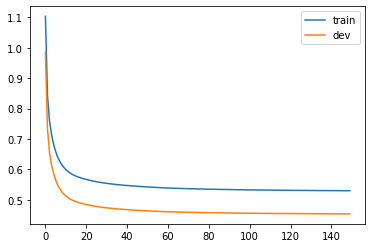

In [23]:
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()

In [45]:
pronunciations.loc['environment'].pronunciation

('ɪ', 'n', 'ˈ', 'v', 'aɪ', 'r', 'ə', 'n', 'm', 'ə', 'n', 't')

In [47]:
pronunciation = ('ɪ', 'n', 'ˈ', 'v', 'aɪ', 'r', 'ə')
sorted(model.next_probabilities(pronunciation).items(), key=lambda p: -p[1])

[('<END>', 0.23827940225601196),
 ('n', 0.18405938148498535),
 ('l', 0.12095028162002563),
 ('t', 0.11505918204784393),
 ('s', 0.1045665368437767),
 ('ˌ', 0.09903314709663391),
 ('m', 0.03616911917924881),
 ('z', 0.017551984637975693),
 ('d', 0.015750762075185776),
 ('b', 0.014727246947586536),
 ('k', 0.012879342772066593),
 ('dʒ', 0.009734299033880234),
 ('p', 0.006754468195140362),
 ('ʃ', 0.004392565228044987),
 ('f', 0.0037111674901098013),
 ('v', 0.0027258722111582756),
 ('ŋ', 0.0022488520480692387),
 ('tʃ', 0.0021722023375332355),
 ('ˈ', 0.0016706361202523112),
 ('w', 0.001512062270194292),
 ('h', 0.0010829651728272438),
 ('g', 0.001038959133438766),
 ('θ', 0.0010268627665936947),
 ('ɪ', 0.0007660716073587537),
 ('ə', 0.0006719491793774068),
 ('ɝ', 0.00032007807749323547),
 ('r', 0.0002714544825721532),
 ('i', 0.0002026021684287116),
 ('ʒ', 0.0001496801123721525),
 ('aɪ', 8.44288369989954e-05),
 ('ð', 8.016002539079636e-05),
 ('eɪ', 7.193924830062315e-05),
 ('iː', 6.54843170195818

In [54]:
from sonorous.languagemodel import build_data_loader
train_loader = build_data_loader(train_pronunciations.pronunciation.values.tolist(), vocab)
dev_loader = build_data_loader(dev_pronunciations.pronunciation.values.tolist(), vocab)
all_loader = build_data_loader(pronunciations.pronunciation.values.tolist(), vocab)

In [52]:
model.evaluate(train_loader)

0.5294013107031621

In [53]:
model.evaluate(dev_loader)

0.45317746707209383

In [55]:
model.evaluate(all_loader)

0.4521759484323973

In [ ]:
%%time


param_grid = ParameterGrid({
    'embedding_dimension': [10, 50, 100],
    'hidden_dimension': [10, 50, 100],
})

records = []
for params in tqdm(param_grid):
    model_parameters = ModelParams(rnn_type='gru', num_layers=1, max_epochs=1000, early_stopping_rounds=1, **params)
    model = LanguageModel(vocab, model_parameters, device_name='cuda')

    print('Model Params:', model_parameters)
    
    train_losses, dev_losses = model.fit(
        train_pronunciations.pronunciation.values.tolist(),
        dev_pronunciations.pronunciation.values.tolist()
    )
    
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
        
        record['rnn_type'] = 'rnn'
        record['num_layers'] = 1 
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

In [ ]:
%%time


param_grid = ParameterGrid({
    'embedding_dimension': [50],
    'hidden_dimension': [2],
})

records = []
for params in tqdm(param_grid):
    model_parameters = ModelParams(rnn_type='rnn', num_layers=1, max_epochs=1000, early_stopping_rounds=1, **params)
    model = LanguageModel(vocab, model_parameters, device_name='cpu')

    print('Model Params:', model_parameters)
    
    train_losses, dev_losses = model.fit(
        train_pronunciations.pronunciation.values.tolist(),
        dev_pronunciations.pronunciation.values.tolist()
    )
    
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

In [ ]:
models_df = pd.DataFrame.from_records(records)

There are {meow} models with a dev error of around .76. I'll choose the simplest one, which 

* point out that no matter how low the train error gets, the dev error
* which model parameters fail to ever get to the lowest dev error
* which model parameters overfit the most

* isolate the group of models with about .76 dev error. choose the simplest one.

In [ ]:
t = models_df[(models_df.embedding_dimension==50) & (models_df.hidden_dimension==100) & (models_df.num_layers==3)]
t = t.set_index('epoch')
t.dev_loss.plot()
t.train_loss.plot()
_ = plt.legend()

In [ ]:
models_df.sort_values('dev_loss').iloc[0]

Since the best "model" was at an earlier epoch I don't have access to it. So I'll train a model with that model's parameters and set the number of epochs to MEOW.

In [ ]:
%%time

model = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=50, hidden_dimension=100, num_layers=3,
    max_epochs=69, early_stopping_rounds=69, batch_size=1024,
)

train_loss, dev_loss = model.fit(train_df.pronunciation.values.tolist(), dev_df.pronunciation.values.tolist())

Now that I have what I hope is the best model I can test how well it does on the holdout test set, which I haven't look at at all during the training process.

In [ ]:
test_loader = build_data_loader(test_df.pronunciation.values.tolist(), lm.phoneme_to_idx)
lm.evaluate(test_loader)

In [ ]:
dev_loader = build_data_loader(dev_df.pronunciation.values.tolist(), lm.phoneme_to_idx)
lm.evaluate(dev_loader)

TODO: compute the test error for the final model. Bar chart for the train, dev, and test errors

Comment on findings, probably that test is higher and that's expected because language models are very sensitive to corpus difference (and I probably overfit the dev set)

## Training the Final Model ##
Now that I've found the best parameters for the model according to the dev set I'll train a final model using all of the data. This should increase model performance overall since more data is better, but is also necessary since I'll be using the model to predict probabilities of all English words. If some of those words weren't in the training set they would artificially get lower probabilities. (Another approach here could be to train a model on e.g. 4/5 folds of the data and make predictions about the remaining 1/5, doing that 5 times to get unbiased predictions for all data, but this would have taken much longer to run.)

In [ ]:
%%time

model_params = ModelParams(
    rnn_type='gru', embedding_dimension=50, hidden_dimension=50, num_layers=1,
    max_epochs=3, early_stopping_rounds=3, batch_size=1024
)

language_model = LanguageModel(vocab, model_params, device_name='cpu')

_ = language_model.fit(pronunciations.pronunciation.values)

And finally, I'll save the model so I can use it in the next notebook, `Phoneme Exploration.ipynb`.

In [ ]:
with open('phoneme_language_model.pt', 'wb') as fh:
    model.save(fh)

In [ ]:
pd